In [45]:
import warnings
warnings.filterwarnings("ignore")

import random
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Only for model training for reproducibility
SEED = 19

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# TRAINING

# Load datasets
train_maf = pd.read_csv("train_MAF.csv")
gene_var  = pd.read_csv("gene_variants.csv")
roh       = pd.read_csv("ROH.csv")
sbs       = pd.read_csv("SBS_Signature_HNSC.csv")

sbs_gene_list = set(
    sbs["Gene"].astype(str).str.strip()
)

# Standardize column names
for df in [train_maf, gene_var, roh, sbs]:
    df.columns = df.columns.str.strip().str.replace(" ", "_")

# SBS13 signature presence
train_maf = train_maf.merge(
    gene_var[['Gene']],
    on='Gene',
    how='left',
    indicator=True
)

# Both target label (driver) and SBS13 feature
y_train = (train_maf['_merge'] == 'both').astype(int)  # driver label
train_maf["SBS13"] = train_maf["Gene"].astype(str).str.strip().apply(
    lambda g: 1 if g in sbs_gene_list else 0
)

# Cleanup
train_maf.drop(columns=['_merge'], inplace=True)

# Functional variant classification encoding

vc = train_maf["Variant_classification"].astype(str)

train_maf["is_frameshift"] = vc.str.contains(
    "Frame_Shift", case=False, na=False
).astype(int)

train_maf["is_inframe"] = vc.str.contains(
    "In_Frame", case=False, na=False
).astype(int)

train_maf["is_missense"] = vc.str.contains(
    "Missense", case=False, na=False
).astype(int)

train_maf["is_truncating"] = vc.str.contains(
    "Nonsense|Nonstop", case=False, na=False
).astype(int)

train_maf["is_splice"] = vc.str.contains(
    "Splice", case=False, na=False
).astype(int)

train_maf["is_silent"] = vc.str.contains(
    "Silent", case=False, na=False
).astype(int)

train_maf["is_start_loss"] = vc.str.contains(
    "Translation_Start", case=False, na=False
).astype(int)

# ROH overlap
def check_roh(row):
    hit = roh[
        (roh["Chromosome"] == row["Chromosome"]) &
        (roh["Start"] <= row["Position"]) &
        (roh["End"] >= row["Position"])
    ]
    return 1 if not hit.empty else 0

train_maf["in_roh"] = train_maf.apply(check_roh, axis=1)

# Recurrence
train_maf["recurrent"] = train_maf.groupby("Gene")["Gene"].transform("count")

# Feature matrix
features = [
    "is_frameshift",
    "is_inframe",
    "is_missense",
    "is_truncating",
    "is_splice",
    "is_silent",
    "is_start_loss",
    "recurrent",
    "in_roh",
    "SBS13"
]

X_train_original = train_maf[features]

y_train_original = train_maf["Gene"].apply(
    lambda g: 1 if g in gene_var["Gene"].values else 0
)

# TRIPLICATION 

def triplicate_training_data(X, y, noise_std=0.01):
    X1 = X.copy()
    X2 = X.copy()
    X3 = X.copy()

    # Add small noise to continuous features only
    noise_cols = ["recurrent"]

    for col in noise_cols:
        if col in X.columns:
            X2[col] = X2[col] + np.random.normal(0, noise_std, len(X2))
            X3[col] = X3[col] + np.random.normal(0, noise_std, len(X3))

    X_trip = pd.concat([X1, X2, X3], ignore_index=True)
    y_trip = pd.concat([y, y, y], ignore_index=True)

    return X_trip, y_trip

X_train, y_train = triplicate_training_data(
    X_train_original,
    y_train_original,
    noise_std=0.05
)

# Train XGBoost model
clf = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    tree_method="hist"
)

clf.fit(X_train, y_train)

# Save model
clf.save_model("driver_model.json")

In [46]:
# INFERENCE PHASE

# Load trained model
clf = xgb.XGBClassifier()
clf.load_model("driver_model.json")

# Load synthetic patient MAF (To be replaced with individual Patient data)
patient_maf = pd.read_csv("synthetic_MAF.csv")

# Standardize column names
patient_maf.columns = patient_maf.columns.str.strip().str.replace(" ", "_")

# Variant classification
vc = patient_maf["Variant_classification"].astype(str)

patient_maf["is_frameshift"] = vc.str.contains("Frameshift", case=False, na=False).astype(int)
patient_maf["is_inframe"] = vc.str.contains("In_Frame", case=False, na=False).astype(int)
patient_maf["is_missense"] = vc.str.contains("Missense", case=False, na=False).astype(int)
patient_maf["is_truncating"] = vc.str.contains("Nonsense|Nonstop", case=False, na=False).astype(int)
patient_maf["is_splice"] = vc.str.contains("Splice", case=False, na=False).astype(int)
patient_maf["is_silent"] = vc.str.contains("Silent", case=False, na=False).astype(int)
patient_maf["is_start_loss"] = vc.str.contains("Translation_Start", case=False, na=False).astype(int)

# Recurrence
gene_recurrence = train_maf["Gene"].value_counts().to_dict()
patient_maf["recurrent"] = patient_maf["Gene"].map(gene_recurrence).fillna(1)

# ROH overlap
def check_roh_patient(row):
    hit = roh[
        (roh["Chromosome"] == row["Chromosome"]) &
        (roh["Start"] <= row["Position"]) &
        (roh["End"] >= row["Position"])
    ]
    return 1 if not hit.empty else 0

patient_maf["in_roh"] = patient_maf.apply(check_roh_patient, axis=1)

# SBS13 annotation
patient_maf["SBS13"] = patient_maf["Gene"].apply(
    lambda g: 1 if g in sbs_gene_list else 0
)

# Feature matrix
features = [
    "is_frameshift",
    "is_inframe",
    "is_missense",
    "is_truncating",
    "is_splice",
    "is_silent",
    "is_start_loss",
    "recurrent",
    "in_roh",
    "SBS13"
]
X_patient = patient_maf[features]

# Predict driver scores
patient_maf["DRIVER_SCORE"] = clf.predict_proba(X_patient)[:, 1]

# Rank results
patient_results = patient_maf.sort_values(
    "DRIVER_SCORE", ascending=False
)

patient_results.to_csv(
    "synthetic_patient_results.csv",
    index=False
)

top10 = patient_results.head(10) # Small number taken due to small dataset. Can be adjusted for larger dataset.

top10[
    ["Gene", "Variant_classification", "Chromosome", "Position", "DRIVER_SCORE"]
].to_csv(
    "synthetic_patient_top10_drivers.csv",
    index=False
)

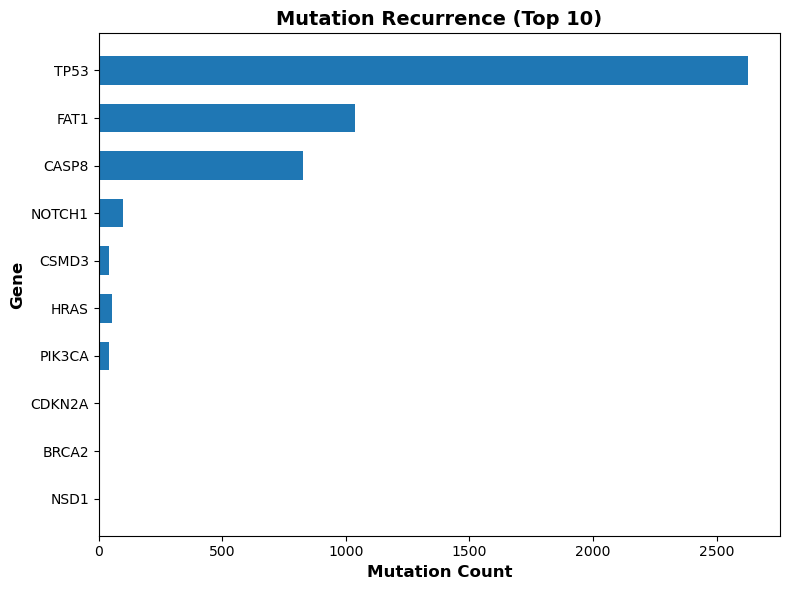

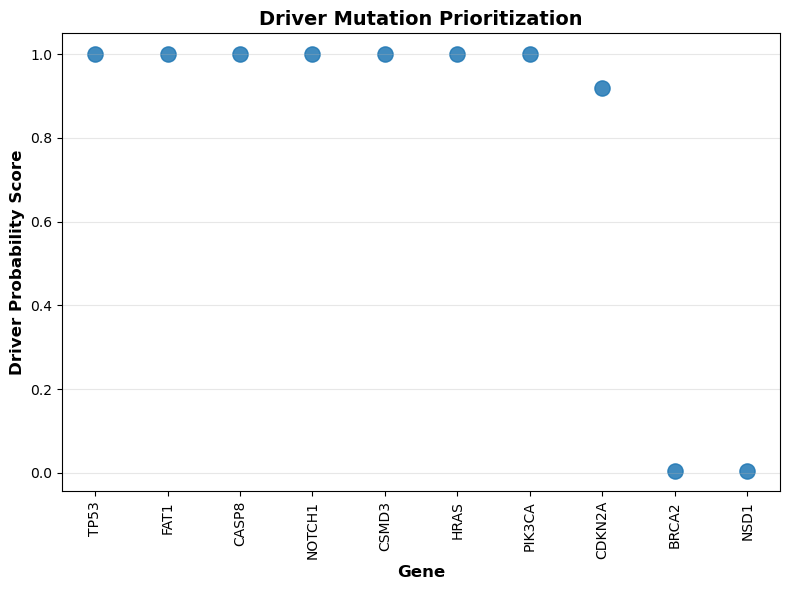

In [47]:
# MUTATION RECURRENCE

plt.figure(figsize=(8, 6))

plt.barh(
    top10["Gene"],
    top10["recurrent"],
    height=0.6
)

plt.gca().invert_yaxis()
plt.xlabel("Mutation Count", fontsize=12, fontweight="bold")
plt.ylabel("Gene", fontsize=12, fontweight="bold")
plt.title("Mutation Recurrence (Top 10)", fontsize=14, fontweight="bold") # Should be adjusted for top driver genes

plt.tight_layout()
plt.savefig(
    "mutation_recurrence.png",
    dpi=600,
    bbox_inches="tight"
)
plt.show()
plt.close()

# PLOT 2: DRIVER PRIORITIZATION

plt.figure(figsize=(8, 6))

x_vals = np.arange(len(top10))
y_vals = top10["DRIVER_SCORE"]

plt.scatter(
    x_vals,
    y_vals,
    s=120,
    alpha=0.85
)

plt.xticks(
    x_vals,
    top10["Gene"],
    rotation=90,
    fontsize=10
)

plt.xlabel("Gene", fontsize=12, fontweight="bold")
plt.ylabel("Driver Probability Score", fontsize=12, fontweight="bold")
plt.title("Driver Mutation Prioritization", fontsize=14, fontweight="bold")

plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(
    "driver_prioritization.png",
    dpi=600,
    bbox_inches="tight"
)
plt.show()
plt.close()